
# Análisis de Frecuencia de Colectivos  
**Autor:** Ernesto Llampa  
**Fechas analizadas:** Parámetros definidos en el notebook  
**Descripción:**  
Este notebook analiza datos de arribos de colectivos, obtenidos mediante un script de mi autoría que recoge información cada 5 minutos. El script se ejecuta de forma continua (24/7) en una Raspberry Pi Zero 2W y está disponible en el siguiente repositorio:

El objetivo es medir la **frecuencia horaria** de los colectivos y detectar patrones de servicio,  
aplicando filtros para reducir registros redundantes y obtener información más precisa.


## 1. Importacion de Librerias usadas:

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



## 2. Carga de Datos:
Se carga el archivo .CSV y se muestran las primeras filas para explorar la estructura del mismo.


In [16]:

# Ruta de mi archivo .CSV
CSV_PATH = "/Users/ernesto/Documents/proyecto datos paradas colectivos/colectivos_log.csv"
df = pd.read_csv(CSV_PATH)
df.head()


,fecha,hora,parada,linea,identificadorCoche,esAdaptado,tiempo_min,distancia_km
0,2025-09-13,23:32:47,7881,120,369(C),False,13,3.593144
1,2025-09-13,23:32:47,5742,128 R,3891,False,8,2.334265
2,2025-09-13,23:33:56,7881,120,369(C),False,13,3.593144
3,2025-09-13,23:33:56,5742,128 R,3891,False,5,1.964569
4,2025-09-13,23:33:56,5742,122 VERDE,4342,False,21,4.182134



## 3. Ajuste de Parámetros de análisis
Se definen las fechas de análisis, las líneas de colectivo de interés y el umbral de distancia para filtrar repeticiones.


In [17]:

# Parámetros
FECHA_INICIO = "2025-09-16"
FECHA_FIN    = "2025-09-16"
LINEAS_INTERES = ["122 VERDE", "122 ROJA", "153 N", "153 R"]
UMBRAL_DISTANCIA_KM = 1.6 #Filtra los colectivos arriba de 1.6 km para evitar arribos duplicados.



## 4. Preprocesamiento y Filtros:
Se filtran los datos por rango de fechas, por línea y por umbral de distancia, eliminando registros redundantes.

1. Conversión de `fecha` y `hora` a una columna `datetime`.  
2. Filtro por rango de fechas (`FECHA_INICIO` a `FECHA_FIN`).  
3. Filtro por líneas de interés (`LINEAS_INTERES`).  
4. Ordenamiento por coche y tiempo.  
5. Filtro por diferencia mínima de distancia (`UMBRAL_DISTANCIA_KM`).  


In [18]:

# Conversión de fechas
df['datetime'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'])
df['fecha'] = pd.to_datetime(df['fecha']).dt.date

# Filtro por rango de fechas
fecha_inicio_dt = pd.to_datetime(FECHA_INICIO).date()
fecha_fin_dt = pd.to_datetime(FECHA_FIN).date()

df = df[(df['fecha'] >= fecha_inicio_dt) & (df['fecha'] <= fecha_fin_dt)]

# Filtro por líneas de interes
df = df[df['linea'].isin(LINEAS_INTERES)]
print(f"Registros seleccionados: {len(df)}")

# Ordenar por coche y tiempo
df = df.sort_values(['identificadorCoche', 'datetime'])

# Filtro por distancia mínima
df['delta_distancia'] = df.groupby('identificadorCoche')['distancia_km'].diff().abs()
df = df[df['delta_distancia'].isna() | (df['delta_distancia'] > UMBRAL_DISTANCIA_KM)]
print(f"Registros luego del filtro por distancia: {len(df)}")

df.head()


Registros seleccionados: 2165
Registros luego del filtro por distancia: 377


,fecha,hora,parada,linea,identificadorCoche,esAdaptado,tiempo_min,distancia_km,datetime,delta_distancia
8331,2025-09-16,12:46:00,7881,153 N,1201(A),False,69,3.126696,2025-09-16 12:46:00,NaN
8413,2025-09-16,13:06:17,7881,153 N,1201(A),False,49,0.484092,2025-09-16 13:06:17,2.642604
8483,2025-09-16,13:26:34,7881,153 N,1201(A),False,29,4.185631,2025-09-16 13:26:34,1.779454
9384,2025-09-16,17:24:53,7881,153 N,1201(A),False,52,1.392683,2025-09-16 17:24:53,2.603238
9450,2025-09-16,17:45:14,7881,153 N,1201(A),False,32,2.731762,2025-09-16 17:45:14,2.025969



## 5. Análisis y Agrupación:
Se calcula la **frecuencia horaria** de colectivos:  
- Agrupación por línea, hora y coche único.  
- Conteo de coches únicos por hora.  
- Si el rango incluye varios días, se divide entre la cantidad de días para obtener un **promedio horario**.  


In [19]:

# Extraer hora del día
df['hora_del_dia'] = df['datetime'].dt.hour

# Calcular cantidad de días en el rango
dias_en_rango = (fecha_fin_dt - fecha_inicio_dt).days + 1
print(f"Días en el rango: {dias_en_rango}")

# Agrupación
frecuencia = (
    df.groupby(['linea', 'hora_del_dia', 'identificadorCoche'])
    .size()
    .reset_index(name='count')
    .groupby(['linea', 'hora_del_dia'])
    .size()
    .reset_index(name='frecuencia')
)

# Promedio si hay varios días
if dias_en_rango > 1:
    frecuencia['frecuencia'] /= dias_en_rango
    print("Mostrando PROMEDIO diario por hora.")
else:
    print("Mostrando datos SOLO DEL DIA seleccionado (sin promedio).")

frecuencia.head()


Días en el rango: 1
Mostrando datos SOLO DEL DIA seleccionado (sin promedio).


,linea,hora_del_dia,frecuencia
0,122 ROJA,3,1
1,122 ROJA,4,1
2,122 ROJA,5,2
3,122 ROJA,6,6
4,122 ROJA,7,8



## 6. Visualización:
Se generan gráficos de barras por cada línea de colectivo, mostrando la frecuencia horaria.  
Los valores numéricos se incluyen encima de cada barra para facilitar la lectura.  


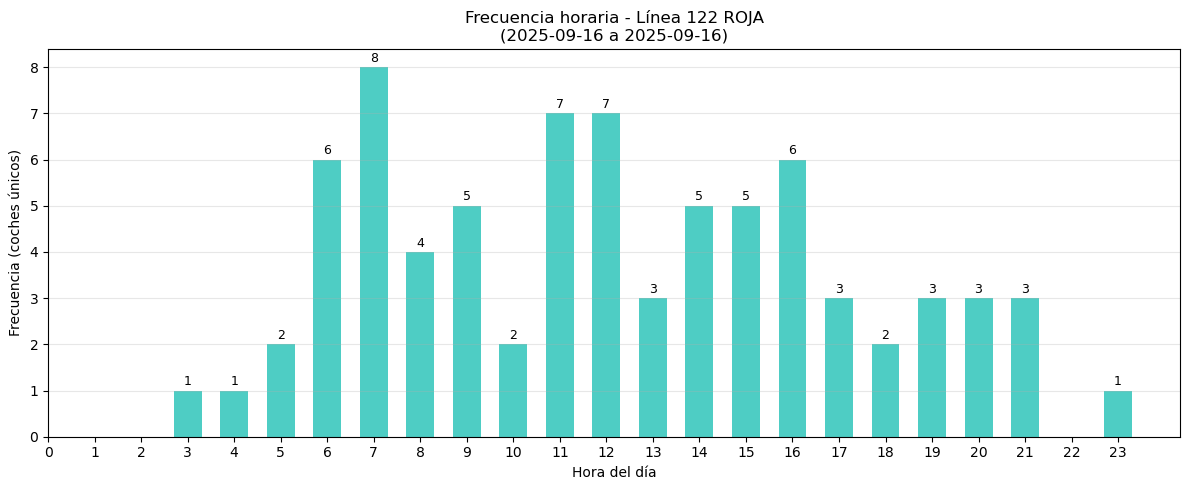

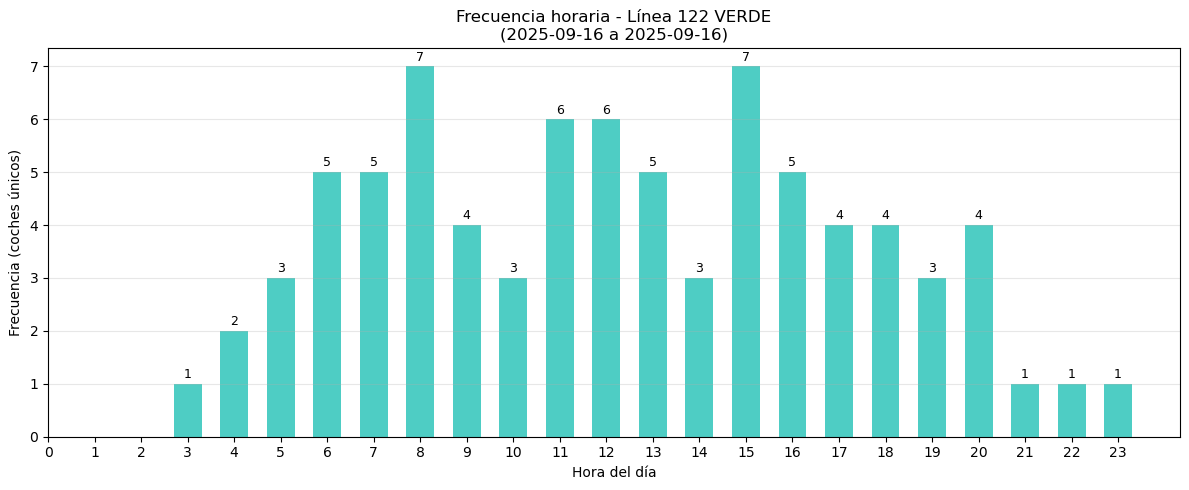

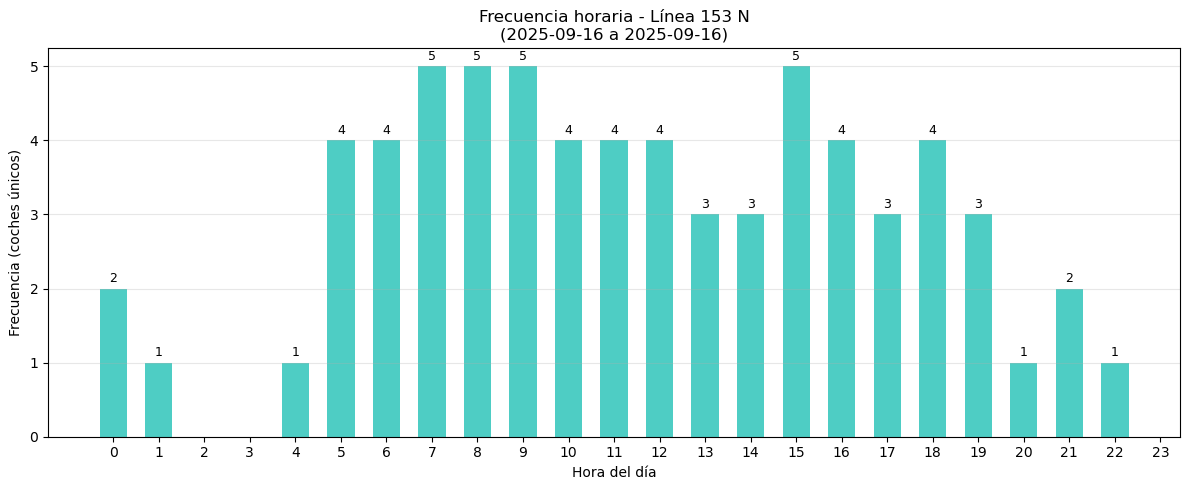

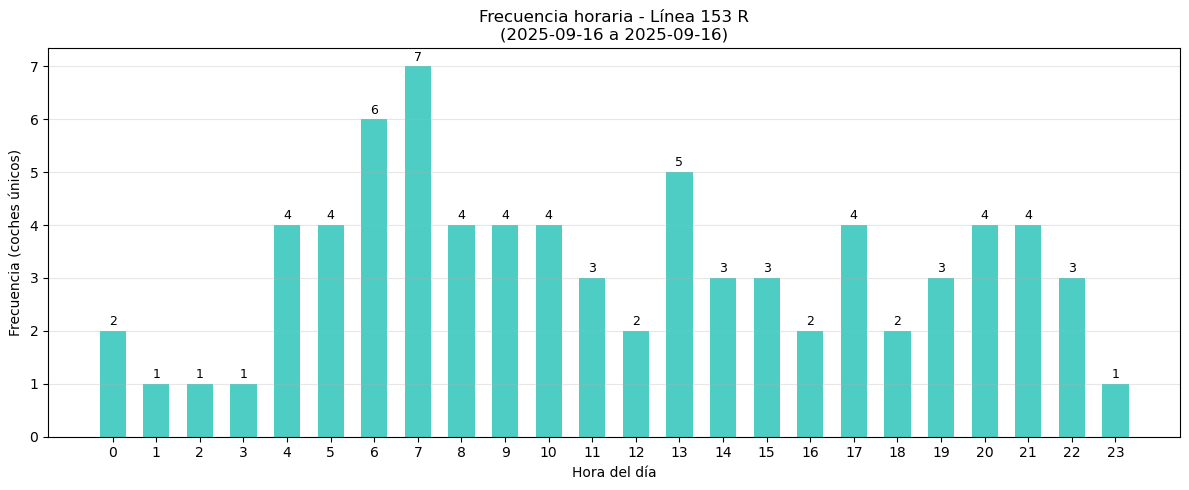

In [20]:

# Gráfico de barras
for linea in frecuencia['linea'].unique():
    datos_linea = frecuencia[frecuencia['linea'] == linea]

    horas = datos_linea['hora_del_dia']
    freq = datos_linea['frecuencia']

    plt.figure(figsize=(12, 5))
    plt.bar(horas, freq, width=0.6, color="#4ECDC4")

    plt.xticks(np.arange(0, 24, 1))
    plt.xlabel("Hora del día")
    plt.ylabel("Frecuencia promedio" if dias_en_rango > 1 else "Frecuencia (coches únicos)")
    plt.title(f"Frecuencia horaria - Línea {linea}\n({FECHA_INICIO} a {FECHA_FIN})")
    plt.grid(axis='y', alpha=0.3)

    # Valores sobre las barras
    for x, y in zip(horas, freq):
        plt.text(x, y + 0.05, str(round(y, 1)), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()



## 7. Conclusiones:
- El análisis permite identificar los horarios con mayor y menor frecuencia de colectivos.  
- El filtrado por **distancia mínima** ayudó a reducir repeticiones y obtener datos más realistas.  
- Los gráficos muestran claramente los patrones de cada línea en el rango de fechas seleccionado.
- La **mayor frecuencia** de la líneas es entre las **7hs** y **8hs** (mayor demanda debido al comienzo de jornada laboral y de clases)
- Se puede observar que las lineas en promedio muestran una **caída en el servicio** a partir de las 21hs.
- El filtrado por distancia eliminó aproximadamente el **84.7%** de registros redundantes para la fecha "2025-09-16"  

Este notebook es fácilmente reutilizable modificando los **parámetros de entrada** (fechas, líneas, umbral).  
